In [31]:
#Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [32]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("Data/cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [33]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rate'}, xlabel='Date'>

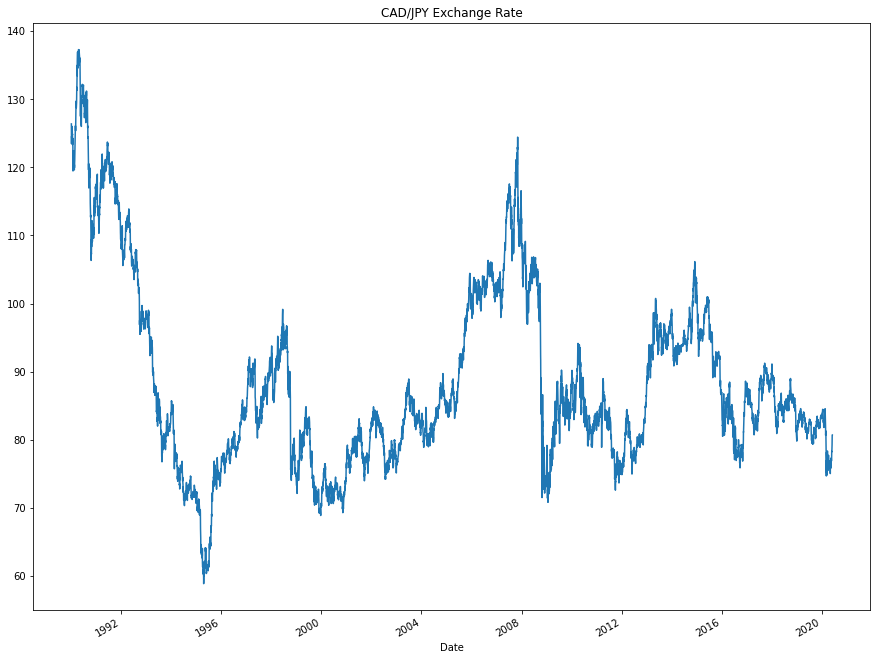

In [34]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df['Price'].plot(title="CAD/JPY Exchange Rate",figsize=(15,12))

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** From the chart above, the CAD/JPY has been on downward trend, from the highs of approx ~138 in 1992 to lows of approx ~75 in 2020. The general trend has been price falling from previous high followed by some recovery in price and again downward trend.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [35]:
# Applying Hodrick Prescott Filter to decompose the exchange rate price into trend and non trend components
import statsmodels.api as sm

ts_noise,ts_trend=sm.tsa.filters.hpfilter(cad_jpy_df['Price'])

<AxesSubplot:title={'center':'Hodrick Prescott Filter - Trend Component of CAD/JPY'}, xlabel='Date'>

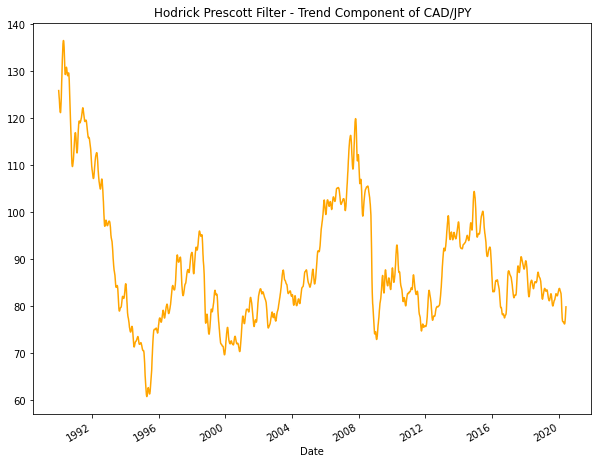

In [36]:
# Plotting the trend component 
ts_trend.plot(color="orange",title ="Hodrick Prescott Filter - Trend Component of CAD/JPY",figsize=(10,8))

<AxesSubplot:title={'center':'Hodrick Prescott Filter - Noise Component of CAD/JPY'}, xlabel='Date'>

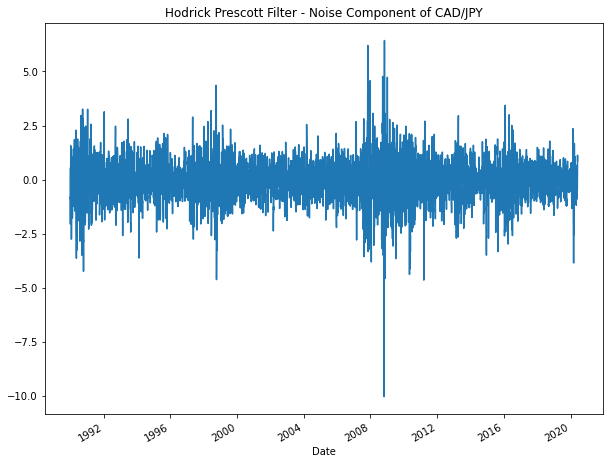

In [37]:
# Plotting the noise component
ts_noise.plot(title ="Hodrick Prescott Filter - Noise Component of CAD/JPY",figsize=(10,8))

In [38]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_hp_df=pd.concat([cad_jpy_df["Price"],ts_trend,ts_noise],axis="columns",join="inner")
cad_jpy_hp_df.rename (columns={"Price_trend":"Trend","Price_cycle":"Noise"},inplace=True)

In [39]:
cad_jpy_hp_df.head()

,Price,Trend,Noise
Date,,,
1990-01-02,126.37,125.850905,0.519095
1990-01-03,125.30,125.679684,-0.379684
1990-01-04,123.46,125.508788,-2.048788
1990-01-05,124.54,125.338304,-0.798304
1990-01-08,124.27,125.167037,-0.897037


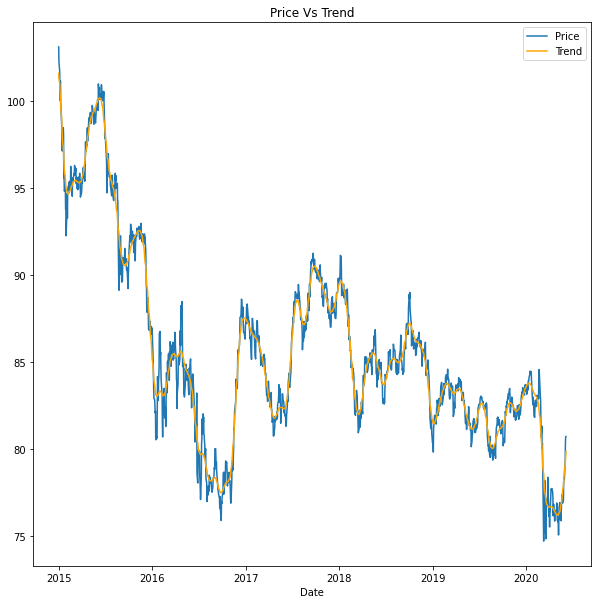

In [41]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(cad_jpy_hp_df["Price"].loc["2015":],label="Price")
ax.plot(cad_jpy_hp_df["Trend"].loc["2015":],label="Trend",color="orange")
ax.set_xlabel("Date")
ax.set_title("Price Vs Trend")
ax.legend()
plt.show()

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Price has been falling from the highs of 2015. The long term trend has been decline in CAD/JPY rates, the CAD/JPY has been lower highs and lower lows. In the near term, it can be expected for CAD/JPY rates to fall further.

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

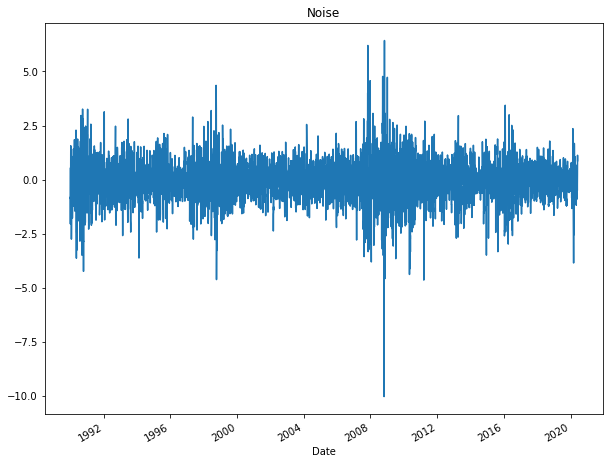

In [42]:
# Plot the  Noise
cad_jpy_hp_df["Noise"].plot(title="Noise",figsize=(10,8))

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [43]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [44]:
#Checking whether the data is Stationary using Augmented Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
adfuller(returns)

(-19.0038637954444,
 0.0,
 23,
 7904,
 {'1%': -3.4311776094390547,
  '5%': -2.861905743461419,
  '10%': -2.5669646805907993},
 19420.66542277558)

#### At 95% confidence level, with p-value < 0.05  the returns data is stationary

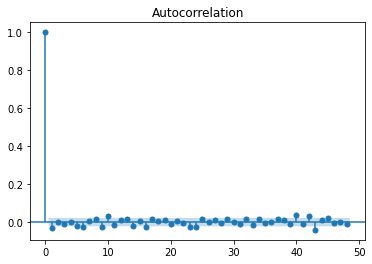

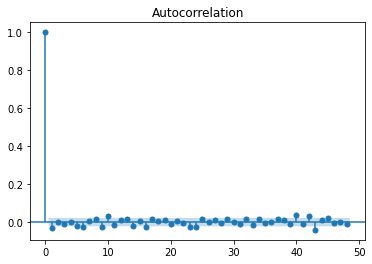

In [45]:
# Plotting Autocorrelation Functionand Partial Autocorrelation Function to identify the order of ARMA model to be used
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# plot_acf measures autocorrelation at different lags
plot_acf(returns.values,lags=48)

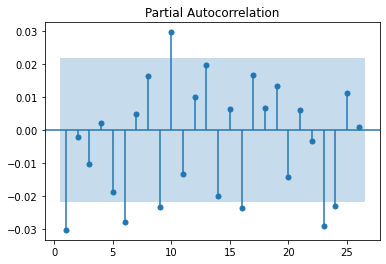

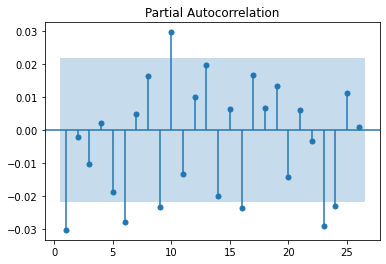

In [16]:
plot_pacf(returns.values,lags=26,zero=False)

In [17]:
from statsmodels.tsa.arima_model import ARMA

# Estimate and ARMA model using statsmodels (use order=(2, 1))
arma_model=ARMA(returns.values,order=(2,1))

# Fit the model and assign it to a variable called results
arma_results=arma_model.fit()

In [18]:
# Output model summary results:
arma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Tue, 20 Jul 2021   AIC                          19513.955
Time:                        21:03:12   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1705           +0.0000j           42.1705            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

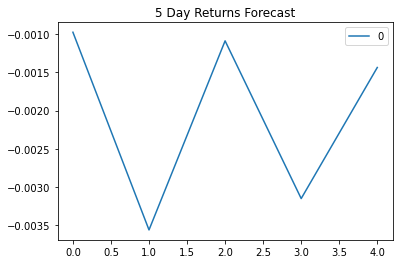

In [19]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(arma_results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** For 95% confidence levels, p value is significant at AR Lag 1 and MA Lag 2 as they are less than 0.05. As AR Lag 2 is not significant, we can choose ARMA model of order (1,1)

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [46]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
arima_model=ARIMA(cad_jpy_df["Price"],order=(5,1,1))

# Fit the model
arima_results=arima_model.fit()

In [47]:
# Output model summary results:
arima_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Wed, 21 Jul 2021   AIC                          17507.244
Time:                        21:11:22   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

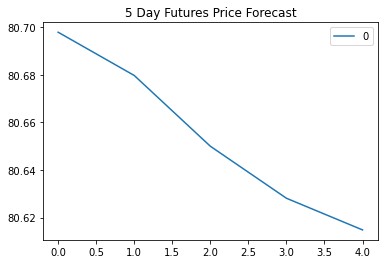

In [91]:
# Plot the 5 Day Price Forecast
pd.DataFrame(arima_results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** ARIMA model is predicting the fall in CAD/JPY rates ie CAD is strengthening against Yen. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [25]:
import arch as arch

In [26]:
# Estimate a GARCH model:
from arch import arch_model
garch_model =arch_model(returns,
                        mean="zero",
                        vol="GARCH",
                        p=2,
                        q=1
                       
                       )

# Fit the model
garch_results=garch_model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 569545243.4284524
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838552966728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11769.086094978014
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.350185312931
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.366479560163
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.111921464748
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027336222945
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.02203125968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021014202204
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020776838068
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764888566
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.02076489123
Optimization terminated successfully    (Exit mode 0)
          

In [27]:
# Summarize the model results
garch_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Tue, Jul 20 2021   Df Residuals:                     7928
Time:                        21:06:57   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [99]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [102]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

# Start the forecast using the last_day calculated above
garch_forecasts=garch_results.forecast(start=last_day,horizon=forecast_horizon)
garch_forecasts

In [103]:
# Annualize the forecast
intermediate = np.sqrt(garch_forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [105]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

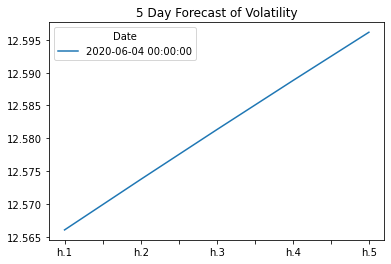

In [106]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** GARCH Model is predicting increasing volatility for next 5 days.

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

**Answer** The 5 day forecat ARIMA model is showing  further fall in CAD/JPY rates, whereas 5 day Forecast based on ARMA model shows rates toggling betwen upward and downward trend. CAD/JPY has been long term downward trend. As there are conflicting signals from different models, it would further investigation is needed before a buy/sell deceision is made.

2. Is the risk of the yen expected to increase or decrease?
**Answer** GARCH model forecast incresing volatility for next 5 days. Increased Volatity increases the associated risk with any position.

3. Based on the model evaluation, would you feel confident in using these models for trading?
 
 **Answer** No, I would not be confident to use these models for trading. For ARMA model the p value for AR Lag 2 >0.05, hence model needs tweaking. Similarly, ARIMA model most the lags have p value >0.05, which implies model needs to reworked. 